<a href="https://colab.research.google.com/github/ttobaegi/ml-on-gcp/blob/main/ML_Debugging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Debugging practice : Debugging a Simple Model

- Why ML debugging is harder than traditional debugging 
- *debugging a simple regression problem with one feature and one label*.


> 1. Create the dataset.
> 2. Try to fit the data with a simple model.
> 3. Debug the model.
> 4. Demonstrate exploding gradients.





## Create the Dataset

In [1]:
# Reset environment for a new run
% reset -f

# Load Libraries
from os.path import join # for joining file pathnames
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
# Create the data :  1 feature with values 0 to 9  &  labels : the same data with some noise added
# To match the convention (rows are examples and columns are features), transpose data. 
# Before transposing vectors, MUST convert them to matrices.

features = np.array(range(10))
features = features[:, np.newaxis]
# Create labels by adding noise distributed around 0
labels = features + np.random.random(size=[10,1]) - 0.5

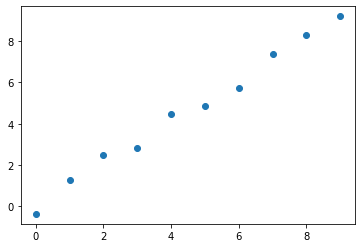

In [3]:
# Verify that the data roughly lies in a straight line and, therefore, is easily predicted
# Visualize the data
plt.scatter(features,labels)

## Fit Simple Data with Simple Model

`Keras API` to train models quickly in a few lines of code using high-level APIs. 
- typical nn : `sequential` model with fully-connected, or `dense`, layers.

- simple dataset ⇒ neural network with just 1 neuron 
- Define a neural network with 1 layer having 1 neuron using the model type `keras.Sequential` with the layer type `keras.layers.Dense`.
- model with 1 layer and 2 parameters (weight and bias) 


In [4]:
# Delete any existing assignment to "model"
model = None

# Use a sequential model
model = keras.Sequential()

# Add a layer with 1 neuron. Use the popular "tanh" activation function
model.add(keras.layers.Dense(units=1,             # 1 neuron
                             activation='tanh',   # 'tanh'
                             input_dim=1))         # number of feature cols=1

# Model calculates loss using mean-square error (MSE)
# Model trains using Adam optimizer with learning rate = 0.001
model.compile(optimizer=tf.optimizers.Adam(0.001),
              loss='mse',
             )

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


Now, train the model.

In [5]:
model.fit(x=features,
          y=labels,
          epochs=10,    # train for 10 epochs
          batch_size=10,# use 10 examples per batch
          verbose=1)    # verbose=1 prints progress per epoch

Epoch 1/10
1/1 [==============================] - 1s 585ms/step - loss: 21.6479
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 21.6478
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 21.6477
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 21.6476
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 21.6475
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 21.6474
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 21.6473
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 21.6472
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 21.6471
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 21.6470


**loss stubbornly refuses to decrease.** 

### To debug your model


* **Transforming data**: You data is not transformed. You can experiment by transforming the data appropriately and retraining the model.
* **Activation function**: The `tanh` activation function cannot predict values >1. Besides, in a regression problem, the last layer should always use the linear activation function. Therefore, should you use  `activation='linear'`?
* **Hyperparameter values**: Should you adjust any hyperparameter values to try reducing loss?
* **Simpler model**: The model development process recommends starting with a simple model. A linear model is simpler than your nonlinear model. Should you use `activation='linear'`?
* **Change optimizer**: The model uses the Adam optimizer. You can fall back to the gradient descent optimizer by using `optimizer=keras.optimizers.SGD()`.


*Reference : [model development process](https://developers.google.com/machine-learning/testing-debugging/common/overview)*




## Solution: Getting Loss to Decrease

Before trying to adjust specific model parameters, such as the hyperparameter values, **first, check for good development practices**,

####  two best practices for linear model
1. Regression: In a regression problem, the last layer must always be linear.
2. Start simple: Since a linear model is simpler than a nonliner model, start with a linear model.

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 1.6921
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 1.5673
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 1.4707
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 1.3754
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 1.2782
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 1.1716
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 1.1033
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 1.0200
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.9388
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 0.8721


Text(0.5, 1.0, 'Loss Curves')

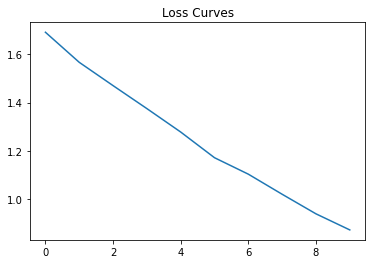

In [6]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse')
trainHistory = model.fit(features, labels, epochs=10, batch_size=1, verbose=1)
# Plot loss curve
plt.plot(trainHistory.history['loss'])
plt.title('Loss Curves')

loss decreases, albeit slowly! 

## Solution: Reaching Convergence

Q. How can you get your loss to converge? 

> Your loss isn't decreasing fast enough. From the guidance on [Learning Rate](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate), **you can increase the learning rate to train faster**.

- to increase the learning rate to 0.1 ⇒ the model reaches convergence quickly.

In [7]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation='linear', input_dim=1))
model.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')  # to increase the learning rate to 0.1
model.fit(features, labels, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
10/10 [==============================] - 0s 1ms/step - loss: 130.4615
Epoch 2/5
10/10 [==============================] - 0s 1ms/step - loss: 49.9405
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 13.4702
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: 2.3852
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 1.7465


quickly get a very low loss



1. confirm the model works by predicting results for values [0,9] 
2. superimposing them on top of the features.

1/1 [==============================] - 0s 68ms/step


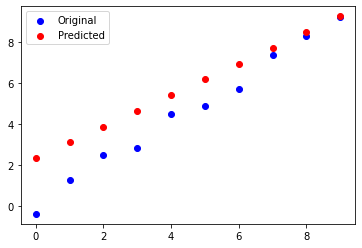

In [8]:
# get predictions
featuresPred = model.predict(features, verbose=1)
# Plot original features and predicted values
featuresPred = np.transpose(featuresPred)
plt.scatter(range(10), labels, c="blue")
plt.scatter(range(10), featuresPred, c="red")
plt.legend(["Original", "Predicted"])

the predictions match the features very well.

## Summary of Case Study

When debugging ML models 

- first attempt to diagnose the problem and apply the appropriate fix
  1. For example, if you had changed your optimizer using `optimizer='sgd'`, then your model also converges faster. 
  2. However, the problem was not with the optimizer but with the learning rate. **Changing the optimizer only helps because `optimizer='sgd'` has a higher default learning rate than `optimizer='adam'`**.

In real-world ML, models take long to train. You should keep your training cycles as short as possible. Therefore, **increasing the learning rate is the correct fix**.

- how debugging in ML is n-dimensional, and therefore you must use your understanding of model mechanics to narrow down your options. 
Because running experiments in ML is time consuming, requires careful setup, and can be subject to reproducibility issues, it's important to use your understanding of model mechanics to  narrow down options without having to experiment.

Lastly, according to development best practices, you should transform your feature data appropriately. This Colab did not transform the feature data because transformation is not required for convergence. However, you should always transform data appropriately. Here, you could normalize your feature data using z-score or scale the feature data to [0,1]. 

# Exploding Gradients

A common problem in model training is a loss that "explodes" or becomes `nan`. A common cause is anomalous feature data, such as outliers and `nan` values, or a high learning rate. The following sections demonstrate these causes.

## Cause: High Learning Rate

Create data in the range [0,50] and show that the gradient explodes when you train the model **using a learning rate of 0.01**. Then you'll reduce the learning rate to make the model converge.


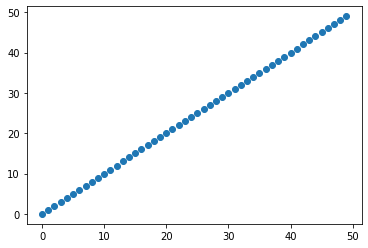

In [9]:
# create data with large values
features = np.array(range(50))
# generate labels
labels = features + np.random.random(features.shape) - 0.5

# Transpose data for input
[features, labels] = [features.transpose(), labels.transpose()]

plt.scatter(range(len(features)), features)

Run the following cell to train a model with a learning rate of 0.01. You will get `inf` for your loss.

In [10]:
# Train on raw data
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=1, activation='linear'))
model.compile(optimizer=keras.optimizers.SGD(0.01), loss='mse')
model.fit(features, labels, epochs=5, batch_size=10, verbose=1)

Epoch 1/5
5/5 [==============================] - 0s 2ms/step - loss: 1975263035392.0000
Epoch 2/5
5/5 [==============================] - 0s 2ms/step - loss: 1122488772398462529437696.0000
Epoch 3/5
5/5 [==============================] - 0s 3ms/step - loss: 582886582991681130328971235890823168.0000
Epoch 4/5
5/5 [==============================] - 0s 2ms/step - loss: inf
Epoch 5/5
5/5 [==============================] - 0s 3ms/step - loss: inf


To demonstrate that the high learning rate makes the loss explore, reduce the learning rate to `0.001`. Your loss will converge.

In [12]:
# Train on raw data
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=1, activation='linear'))
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='mse')
model.fit(features, labels, epochs=5, batch_size=10, verbose=1)

Epoch 1/5
5/5 [==============================] - 0s 3ms/step - loss: 330.8571
Epoch 2/5
5/5 [==============================] - 0s 3ms/step - loss: 2.1447
Epoch 3/5
5/5 [==============================] - 0s 3ms/step - loss: 0.0965
Epoch 4/5
5/5 [==============================] - 0s 2ms/step - loss: 0.1099
Epoch 5/5
5/5 [==============================] - 0s 3ms/step - loss: 0.0920


# Conclusion

* The n-dimensional nature of debugging in ML makes ML debugging hard.
* For effective debugging, understanding model mechanics is important.
* Start with a simple model.
* Exploding gradients incorrect normalization in the model, mis-configuration of FeatureColumns, etc., than raw data containing NaNs.